# Convolutional Nerual Network 🧠
### Transfer Learning
- 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 효과적인 방법은 **사전 훈련된 네트워크** 사용 
- **사전 훈련된 네트워크(pretrained network)** : 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터 셋에서 미리 훈련되어 저장된 네트워크 
  - ImageNet : 1400만개의 레이블된 이미지와 1000개의 클래스로 이루어 진 데이터셋 📷

#### 사전 훈련된 네트워크 사용하는 방법❓
  - **특성 추출(Feature Extraction)**
    - 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 추출 
    - 새로운 분류기(Classifier)처음부터 훈련 
    - Trained convolutional base 는 동결해야함!!!❄️

In [ ]:
import warnings 
warnings.filterwarnings(action='ignore') 

In [ ]:
# 파일 압출 해제 
!unzip cats_and_dogs_small.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cats_and_dogs_small/train/cats/cat.333.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.333.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.864.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.864.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.870.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.870.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.680.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.680.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.858.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.858.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.99.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.99.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.694.jpg  
  inflating: __MACOSX/cats_and_dogs_small/train/cats/._cat.694.jpg  
  inflating: cats_and_dogs_small/train/cats/cat.72.jpg  
  inflating: __MACOS

In [ ]:
import os, shutil 

original_db_dir = './train'
base_dir ='./cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Feature Extraction 실습 
  - cats and dogs 데이터셋 사용 

In [ ]:
from keras.applications.vgg16 import VGG16

conv_base= VGG16(
    weights= 'imagenet',        # 가중치 사용 여부 
    include_top = False,        # 맨 마지막인 Classifier는 사용하지 않는다
    input_shape=(150,150,3)
)

conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

#### Feature Extraction 방법 (1)
- 새로운 데이터셋에서 convnet을 실행하고 <u>출력을 numpy배열로 디스크에 저장</u> ➡️ 이 데이터를 독립된 완전연결분류기(1D)에 입력으로 사용 
  - 장점 : 모든 입력 이미지에 대해 'convnet을 1번만 실행하면 되므로 빠르고 비용이 적게듬 
  - 단점 : numpy배열로 입력하기 때문에 data augmentation 사용 불가

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [ ]:
# Fast feature Extraction without data augmentation 
# numpy array 디스크 생성  

def extract_features(dir, sample_count):
  features= np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      dir,
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'binary'
  )
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size: (i+1)*batch_size] = features_batch
    labels[i*batch_size: (i+1)*batch_size] = labels_batch
    i += 1
    if i *batch_size >= sample_count:
      break
  return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels  = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# numpy array 형태로 변경 
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512)) 
test_features = np.reshape(test_features, (1000, 4*4*512))

* Classifier model 생성 및 훈련 

In [ ]:
from keras.layers import Dense, Dropout
from keras import models 

model = models.Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# model compile 
from tensorflow.keras import optimizers

model.compile(optimizer= optimizers.RMSprop(lr=2e-5),
              loss = 'binary_crossentropy',
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# 모델 훈련 
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

model.save('cats_and_dogs_small_3.h5')

Epoch 1/30
100/100 [==============================] - 4s 31ms/step - loss: 0.6116 - acc: 0.6635 - val_loss: 0.4189 - val_acc: 0.8700
Epoch 2/30
100/100 [==============================] - 3s 26ms/step - loss: 0.4349 - acc: 0.8100 - val_loss: 0.3673 - val_acc: 0.8790
Epoch 3/30
100/100 [==============================] - 3s 26ms/step - loss: 0.3625 - acc: 0.8485 - val_loss: 0.3028 - val_acc: 0.8990
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 0.3234 - acc: 0.8665 - val_loss: 0.3216 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 2s 24ms/step - loss: 0.2967 - acc: 0.8785 - val_loss: 0.2607 - val_acc: 0.9120
Epoch 6/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2688 - acc: 0.8910 - val_loss: 0.2364 - val_acc: 0.9250
Epoch 7/30
100/100 [==============================] - 3s 26ms/step - loss: 0.2547 - acc: 0.8985 - val_loss: 0.2427 - val_acc: 0.9160
Epoch 8/30
100/100 [==============================] - 3s 30ms/step - 

* 그래프로 정확석 판단하기 

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss =history.history['val_loss']

epochs = range(1, len(acc)+1)

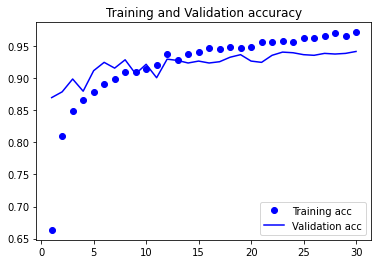

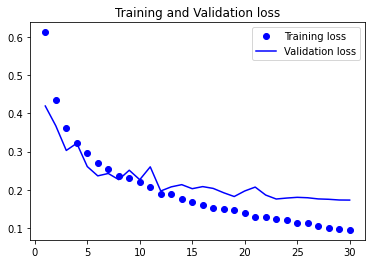

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracy 그래프 
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

# loss 그래프 
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()
plt.show()

#### Feature Extraction 방법 (2)
- 준비한 모델(conv_base)위에 Dense층을 쌓아 확장 ➡️ 입력 데이터에서 end-to-end로 전체 모델을 실행 
  - 장점 : data augmentation사용 가능 
  - 단점 : 훨씬 많은 비용이 듬 

In [ ]:
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = models.Sequential()
model.add(conv_base)        # 준비된 모델을 먼저 쌓고 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


- Complie 하고 훈련하기전에!! conv_base를 동결하는 것이 매우 중요 🔥
  - 훈련하는 동안 가중치가 업데이트 되지 않도록 막음 

In [ ]:
# keras에서는 trainable 속성을 False로 설정하여 네트워크를 동결 
print('conv_base를 동결하기 전 훈련되는 가중치의 수 :', len(model.trainable_weights))
conv_base.trainable = False 
print('conv_base를 동결하 후 훈련되는 가중치의 수 :', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 : 10
conv_base를 동결하 후 훈련되는 가중치의 수 : 4


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. /255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode ='binary'
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# model compile 

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [ ]:
# 모델 훈련 
history = model.fit_generator(
    train_generator,
    steps_per_epoch= train_generator.n// train_generator.batch_size,
    epochs=30,
    validation_data= validation_generator,
    validation_steps= validation_generator.n//validation_generator.batch_size,
    verbose=2,
)

# 모델저장
model.save('cats_and_dogs_small_5.h5')

Epoch 1/30
62/62 - 882s - loss: 0.6143 - acc: 0.6702 - val_loss: 0.5255 - val_acc: 0.7999
Epoch 2/30
62/62 - 878s - loss: 0.5043 - acc: 0.7647 - val_loss: 0.4033 - val_acc: 0.8654
Epoch 3/30
62/62 - 876s - loss: 0.4553 - acc: 0.7967 - val_loss: 0.3389 - val_acc: 0.8841
Epoch 4/30
62/62 - 878s - loss: 0.4195 - acc: 0.8155 - val_loss: 0.3163 - val_acc: 0.8856
Epoch 5/30
62/62 - 877s - loss: 0.4056 - acc: 0.8181 - val_loss: 0.3362 - val_acc: 0.8735
Epoch 6/30
62/62 - 877s - loss: 0.3757 - acc: 0.8420 - val_loss: 0.2841 - val_acc: 0.8942
Epoch 7/30
62/62 - 875s - loss: 0.3781 - acc: 0.8343 - val_loss: 0.2552 - val_acc: 0.9093
Epoch 8/30
62/62 - 885s - loss: 0.3689 - acc: 0.8455 - val_loss: 0.3087 - val_acc: 0.8790
Epoch 9/30
62/62 - 882s - loss: 0.3709 - acc: 0.8379 - val_loss: 0.2735 - val_acc: 0.8967
Epoch 10/30
62/62 - 884s - loss: 0.3374 - acc: 0.8623 - val_loss: 0.2486 - val_acc: 0.9108
Epoch 11/30
62/62 - 877s - loss: 0.3352 - acc: 0.8532 - val_loss: 0.2246 - val_acc: 0.9173
Epoch 12

In [ ]:
# accuracy 그래프 
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

# loss 그래프 
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()
plt.show()

#### 사전 훈련된 네트워크 사용하는 방법❓
  - **Fine Tuning(미세조정)**
    - 특성추출에서 사용했던 동결모델의 상위 층 몇개를 동결에서 해제하고 모델에 새로 추가한 층(완전 연결분류기)와 함께 연결

In [ ]:
conv_base.trainable = True 

set_trainable = False
for layer in conv_base.layers:
  if layer.name =='block5_conv1':
    set_trainable = True 
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
# model compile 
from tensorflow.keras import optimizers

model.compile(optimizer= optimizers.RMSprop(lr=1e-5),
              loss = 'binary_crossentropy',
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n// train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
62/62 [==============================] - 876s 14s/step - loss: 0.5076 - acc: 0.7790 - val_loss: 0.4739 - val_acc: 0.7964
Epoch 2/100
62/62 [==============================] - 868s 14s/step - loss: 0.4803 - acc: 0.7790 - val_loss: 0.3756 - val_acc: 0.8760
Epoch 3/100
62/62 [==============================] - 893s 15s/step - loss: 0.4605 - acc: 0.8089 - val_loss: 0.3759 - val_acc: 0.8654
Epoch 4/100
62/62 [==============================] - 892s 15s/step - loss: 0.4392 - acc: 0.8074 - val_loss: 0.3750 - val_acc: 0.8604
Epoch 5/100
62/62 [==============================] - 875s 14s/step - loss: 0.4160 - acc: 0.8257 - val_loss: 0.3403 - val_acc: 0.8790
Epoch 6/100
62/62 [==============================] - 868s 14s/step - loss: 0.4088 - acc: 0.8222 - val_loss: 0.3556 - val_acc: 0.8599
Epoch 7/100
62/62 [==============================] - 876s 14s/step - loss: 0.3914 - acc: 0.8318 - val_loss: 0.2721 - val_acc: 0.8997
Epoch 8/100
62/62 [==============================] - 867s 14s/step - 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss =history.history['val_loss']

epochs = range(1, len(acc)+1)

NameError: ignored

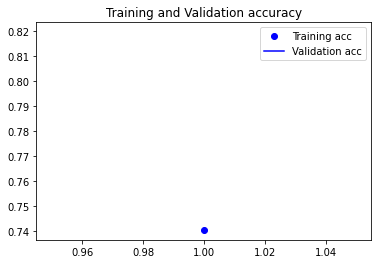

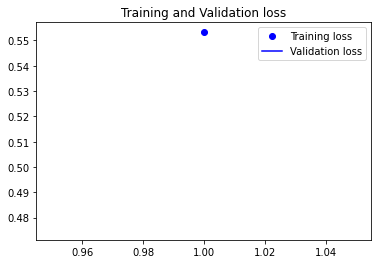

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracy 그래프 
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

# loss 그래프 
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()
plt.show()

* Smooth_curve

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

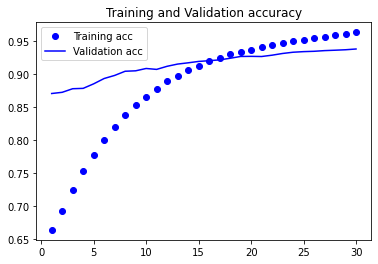

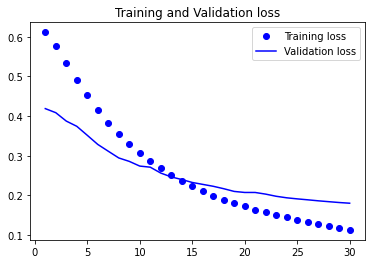

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracy 그래프 
plt.plot(epochs, smooth_curve(acc), 'bo', label = 'Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

# loss 그래프 
plt.plot(epochs, smooth_curve(loss), 'bo', label = 'Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()
plt.show()

## Visualizing what convents learn
모델이 학습한 특징, 근거를 시각화 하는 것, 예를들어 '왜 암으로 판별 했는지', '왜 고양이로 판단했는지' 등등 

- 시각화에 유용한 기법 
  - 컨브넷 중간층의 출력(중간층에 있는 활성화)을 시각화
  - 컨브넷 필터 시각화 
  - 클래스 활성화에 대한 히트맵(heatmap)을 이미지에 시각화 

In [ ]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

### Visualizing Intermediate activations 
- 어떤 입력이 주어졌을 때 네트워크에 있는 여러 **합성곱과 풀링층**이 출력하는 특성맵을 그리는 것
- 네트워크에 의해 **학습된 필터들이 어떻게 입력을 분해**하는 지 보여줌 
- 넓이, 높이, 깊이(채널) 3개의 차원에 대한 특성맵을 시각화하는 것이 좋음 
- 각 채널은 비교적 독립적 특성을 인코딩하므로 특성맵의 각 채널 내용을 독립적인 2D이미지로 그림 

In [ ]:
img_path = './cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image 
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


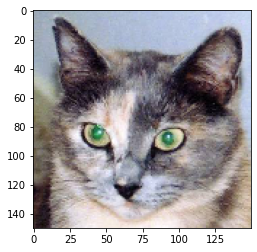

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# 구성한 케라스 모델을 통해 구축 
from keras import models 

# 모델 인스턴스를 만들 때 2개의 파라미터가 필요 (input, output)
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# 입력 이미지가 주어지면 이 모델은 원본 모델의 활성화 값을 반환 
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


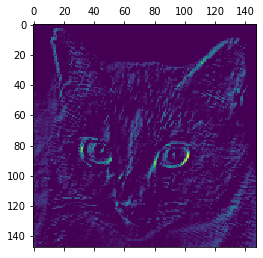

In [ ]:
# 첫번째 층 활성화 중에서 20번째 채널을 시각화 

plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

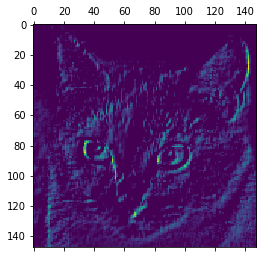

In [ ]:
# 첫번째 층 활성화 중에서 16번째 채널을 시각화 

plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


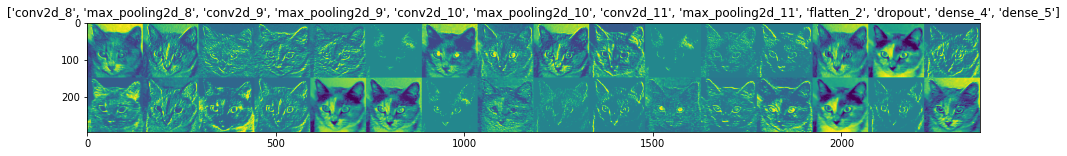

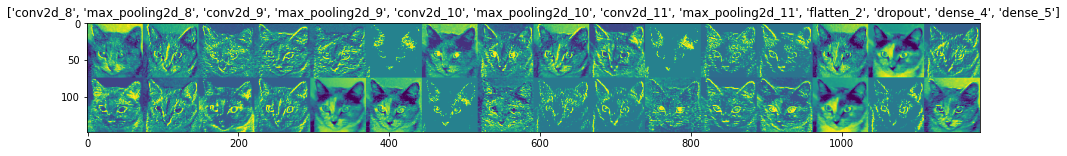

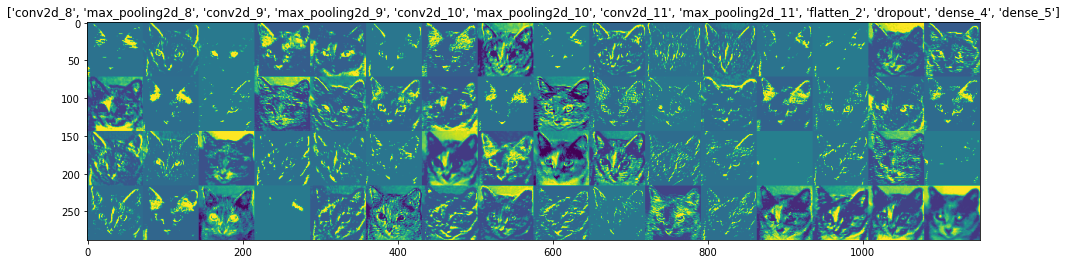

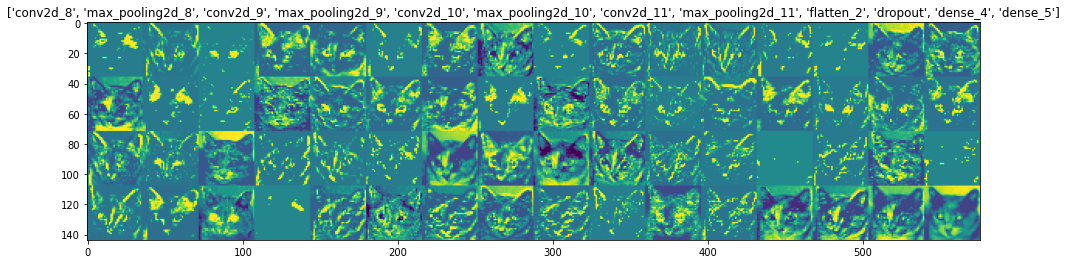

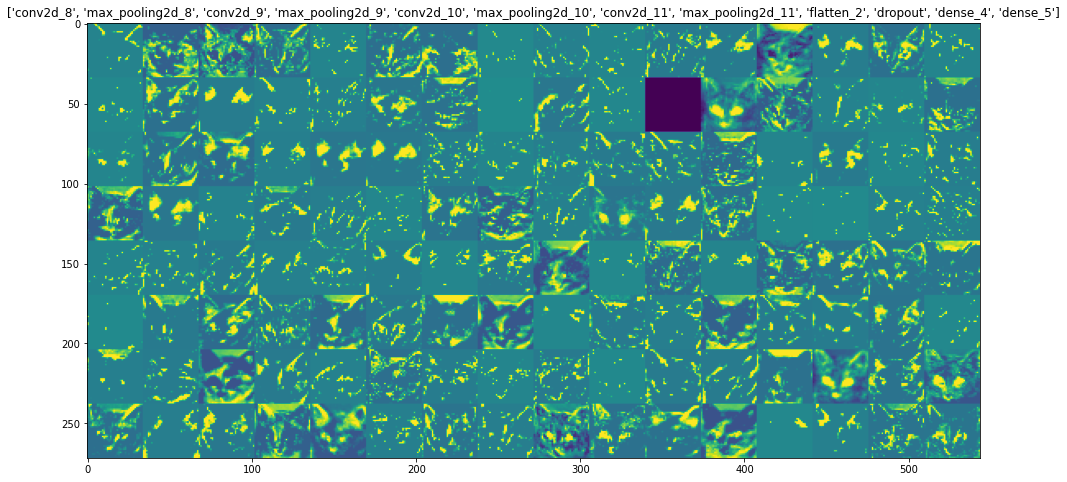

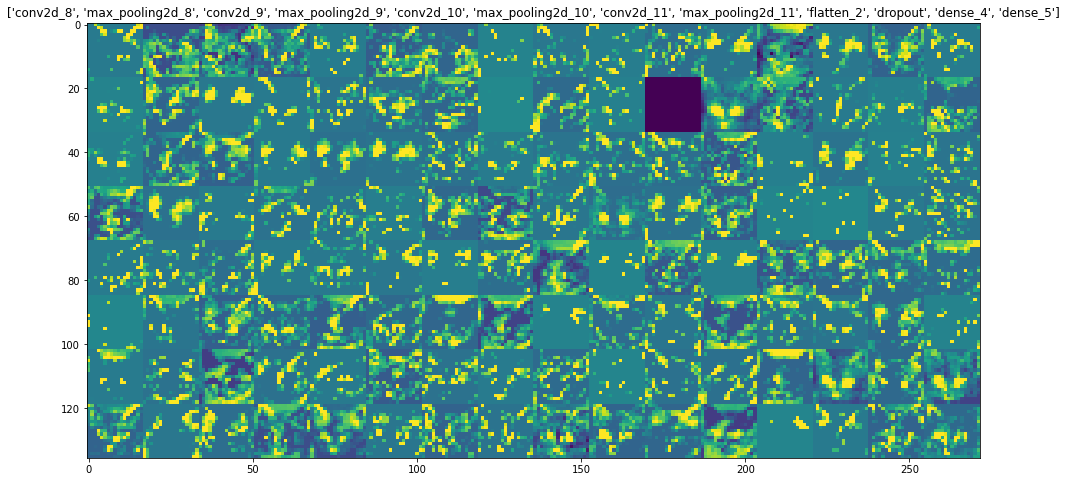

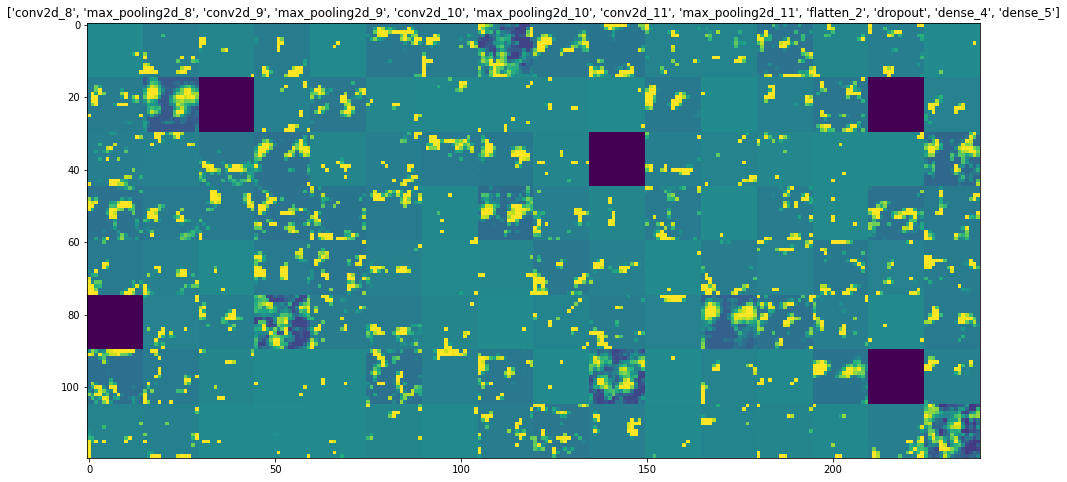

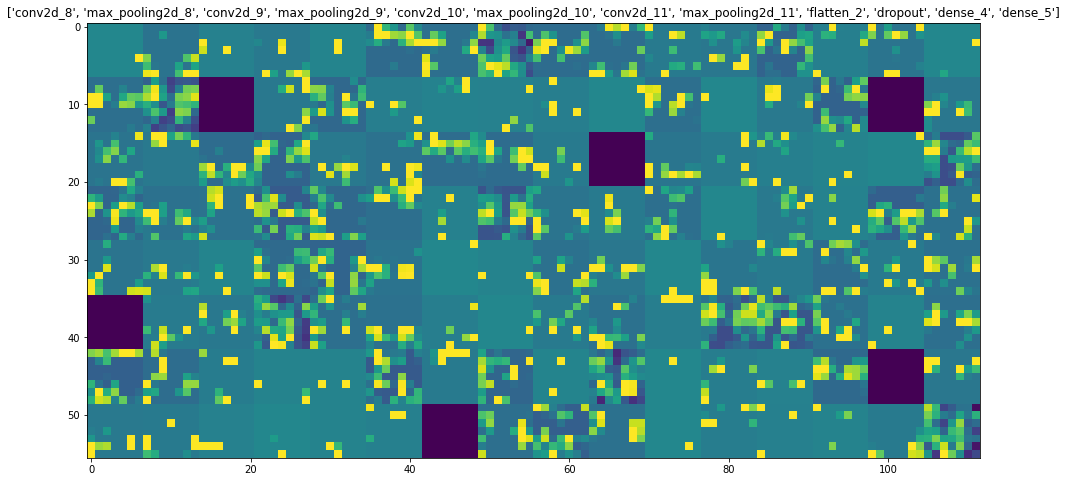

In [ ]:
# 중간층의 모든 활성화 채널 시각화 

layer_names = []
for layer in model.layers[:]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  n_cols = n_features // images_per_row
  display_grid = np.zeros((size*n_cols, images_per_row *size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]

      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col +1) * size, row * size: (row+1)*size]= channel_image

  scale = 1. / size
  plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
  plt.title(layer_names)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')